In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn import (
    feature_selection,
    pipeline,
    svm,
    preprocessing,
    compose,
    model_selection,
)


import warnings
from os import environ

In [11]:
warnings.simplefilter("ignore")
environ["PYTHONWARNINGS"] = "ignore"

In [12]:
kf = model_selection.RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)

In [13]:
df = pd.read_csv("logP-14000.csv").dropna()
y = df.Kow
X = df.iloc[:, 4:]
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,16.859063,16.859063,0.067556,-1.980464,0.667213,52.535714,392.467,363.235,392.199902,154,...,0,0,0,0,0,0,0,0,0,0
1,12.870043,12.870043,0.041293,-1.584704,0.700523,46.241379,404.503,372.247,404.219889,160,...,0,0,0,0,0,0,0,0,0,0
2,13.474536,13.474536,0.062483,-1.645537,0.728839,43.724138,402.487,372.247,402.204239,158,...,0,0,0,0,0,0,0,0,0,0
3,11.975791,11.975791,0.293611,-1.310347,0.736884,18.529412,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,0,1
4,12.770676,12.770676,0.058604,-0.957338,0.410670,36.750000,334.332,316.188,334.127720,128,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14171,5.284200,5.284200,0.394039,0.394039,0.436016,9.833333,333.420,318.300,333.104816,118,...,0,0,0,0,0,0,0,0,0,0
14172,4.530743,4.530743,0.861682,0.861682,0.296905,10.105263,275.461,250.261,275.170771,104,...,0,0,0,0,0,0,0,0,8,0
14173,4.517097,4.517097,0.854678,0.854678,0.350684,9.882353,247.407,226.239,247.139471,92,...,0,0,0,0,0,0,0,0,6,0
14174,5.382033,5.382033,0.608946,0.608946,0.582382,11.090909,306.394,292.282,306.093917,108,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def standardizer(X):
    var_transformer = compose.make_column_transformer(
        (
            feature_selection.VarianceThreshold(0.01),
            X.columns,
        ),
        remainder="drop",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")

    scale_transformer = compose.make_column_transformer(
        (
            preprocessing.StandardScaler(),
            compose.make_column_selector(dtype_include=float),
        ),
        (
            preprocessing.MinMaxScaler(feature_range=(0, 1)),
            compose.make_column_selector(dtype_include=int),
        ),
        remainder="passthrough",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")

    _X = var_transformer.fit_transform(X)
    _X = scale_transformer.fit_transform(_X)

    return _X

In [15]:
_ = X[X.isna().sum(axis=1) > 0]
_.loc[:, _.isna().sum() > 0]

""


In [16]:
svr = svm.SVR()

In [17]:
sfs = SFS(
    estimator=svr,
    k_features=(20, 45),
    forward=True,
    scoring="r2",
    floating=True,
    verbose=2,
    cv=kf,
    n_jobs=-1,
)

In [18]:
pipe = pipeline.Pipeline(
    [
        ("scaler", preprocessing.FunctionTransformer(func=standardizer)),
        ("feature_selector", sfs),
    ]
)

In [19]:
X_ = pipe.fit_transform(X, y)
X_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:  6.2min finished

[2024-02-29 19:51:05] Features: 1/45 -- score: 0.7652287791708431[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:  6.0min finished

[2024-02-29 19:57:08] Features: 2/45 -- score: 0.7841526231115785[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.7s finished

[2024-02-29 20:03:41] Features: 3/45 -- score: 0.7974692407976529[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: D

array([[ 2.29041289, -0.93637865,  0.38118588, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95635347, -0.64734582,  0.57668602, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.15851586, -0.6917738 ,  0.74287108, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.83714614,  1.13419067, -1.47656807, ...,  0.        ,
         0.        ,  0.        ],
       [-1.54788309,  0.95472699, -0.11670228, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05002218,  0.04582822, -1.58901675, ...,  0.        ,
         0.        ,  0.        ]])

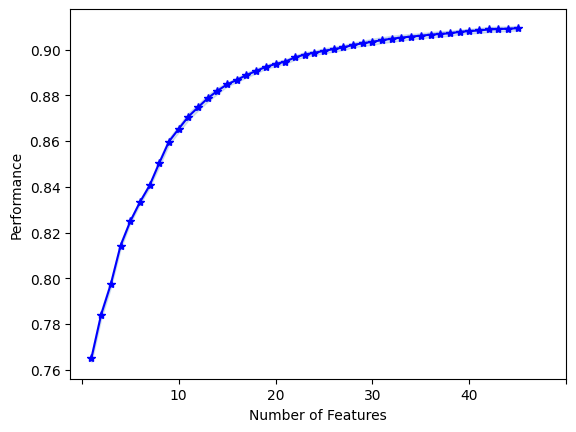

In [20]:
fig = plot_sfs(
    pipe.named_steps["feature_selector"].get_metric_dict(), kind="std_err", marker="*"
)
plt.xticks([x for x in range(0, 55, 10)])
plt.show()

In [21]:
X = pd.DataFrame(
    data=X_, columns=pipe.named_steps["feature_selector"].k_feature_names_
)  # перезаписывание матрицы X, т.к. у SFS из mlxtend нет set_output
X

,MaxAbsEStateIndex,MinEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRLOW,...,VSA_EState3,VSA_EState4,VSA_EState8,VSA_EState9,MolLogP,MolMR,fr_Al_COO,fr_hdrzone,fr_priamide,fr_pyridine
0,2.290413,-0.936379,0.381186,4.482272,-0.515091,0.003284,-2.964145,2.594844,-2.115795,-0.779787,...,2.662477,-2.345166,0.738588,-0.174297,-0.140807,1.219094,0.0,0.0,0.0,0.000000
1,0.956353,-0.647346,0.576686,3.740965,0.459403,-0.625992,-2.840984,2.434860,-1.816570,-0.708750,...,1.658605,-1.068490,0.893434,-0.174297,0.142599,1.391018,0.0,0.0,0.0,0.000000
2,1.158516,-0.691774,0.742871,3.444500,0.459403,-0.625992,-2.679843,2.382299,-1.772244,-0.687013,...,0.422035,-1.175949,0.835888,-0.174297,0.271798,1.354794,0.0,0.0,0.0,0.000000
3,0.657286,-0.446977,0.790090,0.477222,0.676389,1.050291,-1.261884,0.462926,-1.909834,-0.616710,...,-0.356222,-0.855352,-0.214924,-0.174297,-0.882552,-0.224785,0.0,0.0,0.0,0.000000
4,0.923122,-0.189166,-1.124501,2.623129,1.336894,-0.543823,-1.637130,1.795084,-1.537243,-0.613595,...,-0.465513,2.962057,-0.152285,0.644987,-2.341841,0.500492,0.0,0.0,0.5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14158,-1.580602,0.797776,-0.975741,-0.546948,-0.505898,0.543258,0.114102,-0.756704,-0.347303,1.738657,...,0.034650,1.328101,-0.819444,-0.174297,0.678259,1.217899,0.0,0.5,0.0,0.666667
14159,-1.832582,1.139306,-1.792203,-0.514921,-1.652224,1.457134,0.510103,-0.539586,1.261601,0.811775,...,-0.559664,-0.119584,-0.519738,-0.174297,2.066495,0.749200,0.0,0.0,0.0,0.000000
14160,-1.837146,1.134191,-1.476568,-0.541174,-1.652224,1.457134,0.560528,-0.625000,1.260386,0.868184,...,-0.560682,-0.123859,-0.522174,-0.174297,1.582341,0.414642,0.0,0.0,0.0,0.000000
14161,-1.547883,0.954727,-0.116702,-0.398838,-0.432783,0.464914,0.160348,-0.181235,0.435951,1.169004,...,0.106338,0.127704,-0.589104,-0.174297,1.123375,0.851143,0.0,0.0,0.0,0.000000


In [27]:
X.columns

Index(['MaxAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MaxPartialCharge',
       'MinPartialCharge', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW',
       'BCUT2D_MRLOW', 'AvgIpc', 'PEOE_VSA1', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA3',
       'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',
       'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA8', 'EState_VSA7', 'VSA_EState10',
       'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState8',
       'VSA_EState9', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_hdrzone',
       'fr_priamide', 'fr_pyridine'],
      dtype='object')

In [23]:
df = pd.DataFrame(pipe.named_steps["feature_selector"].get_metric_dict()).T
df.iloc[12, :].feature_names

('MaxAbsEStateIndex',
 'MaxPartialCharge',
 'MinPartialCharge',
 'BCUT2D_CHGHI',
 'BCUT2D_MRLOW',
 'PEOE_VSA8',
 'SMR_VSA3',
 'SMR_VSA5',
 'SlogP_VSA1',
 'VSA_EState1',
 'VSA_EState3',
 'MolLogP',
 'fr_Al_COO')

In [35]:
wide_grid = {
    "C": 10 ** np.arange(4.0, -4.0, -2),  ##параметр регуляризации - степень
    # "epsilon": 10 ** np.arange(8., -8., -1),            ##полуширина трубки
    # "gamma": [10 ** np.arange(8., -8., -1), 'scale', 'auto']
}

In [4]:
gs = model_selection.GridSearchCV(
    svr, wide_grid, verbose=3, n_jobs=-1, cv=kf, score="r2"
)

NameError: name 'svr' is not defined

In [37]:
gs.fit(X, y)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


[CV 6/6] END ............................C=0.01;, score=0.584 total time=   8.1s
[CV 2/6] END ............................C=0.01;, score=0.587 total time=   8.8s
[CV 3/6] END .............................C=1.0;, score=0.912 total time=   9.2s
[CV 4/6] END .............................C=1.0;, score=0.911 total time=   9.1s
[CV 2/6] END .............................C=1.0;, score=0.908 total time=   9.2s
[CV 1/6] END .............................C=1.0;, score=0.909 total time=   9.3s
[CV 6/6] END .............................C=1.0;, score=0.905 total time=   9.2s
[CV 5/6] END ............................C=0.01;, score=0.591 total time=   9.3s
[CV 4/6] END ............................C=0.01;, score=0.603 total time=   9.4s
[CV 5/6] END .............................C=1.0;, score=0.911 total time=   9.5s
[CV 1/6] END ............................C=0.01;, score=0.599 total time=   9.4s
[CV 3/6] END ............................C=0.01;, score=0.591 total time=   9.5s
[CV 6/6] END ...............

KeyboardInterrupt: 

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
narrow_grid = {
    "C": np.linspace(0, 10, 20),  ##параметр регуляризации - степень
    "epsilon": 10 ** np.linspace(-2, 0, 20),  ##полуширина трубки
}

In [ ]:
gs_2 = model_selection.GridSearchCV(
    svr,
    narrow_grid,
    verbose=3,
    n_jobs=-1,
    cv=kf,
)

In [ ]:
gs_2.fit(X, y)

In [ ]:
gs_2.best_score_